# Predicting Suburb to Open Flag-ship Restaurant for Bong Foodies Ltd

##  Description & Discussion of the Background

Toronto is the provincial capital of Ontario and the most populous city in Canada, with a population of 2,731,571 as of 2016, the Toronto census metropolitan area (CMA), of which the majority is within the Greater Toronto Area (GTA), held a population of 5,928,040, making it Canada's most populous CMA. The city is the anchor of the Golden Horseshoe, an urban agglomeration of 9,245,438 people (as of 2016) surrounding the western end of Lake Ontario. Toronto is an international center of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world.
Being from India, I decided to use an imaginary Indian restaurant aggregator Bong Foodies Ltd. deciding to open their flagship Indian restaurant in Toronto. I was based out of Mississauga, Canada for more than 1.5 years and visited Toronto a few times. Considering the multi-cultural nature of the city along with a huge population of Asian Origin people coming from India, Bangladesh, Pakistan it made sense for me to choose the city as the location where the company would like to open their flag-ship restaurant.



## Problem Statement

However, considering that it has a lot of boroughs and different type of restaurants, what they wanted to understand was which would be an ideal suburb or borough where the can open it. To solve this problem, they are expecting to answer a few key questions on the neighborhoods in Toronto and recommend a best possible neighborhood. Some of the relevant questions are: 

Which are the busiest neighborhoods in terms of business, retail shops, restaurants?
How many restaurants are there in each of these neighborhoods?
What is the average rating of restaurants in these neighborhoods if possible?
How many restaurants are there in these neighborhoods?
Are there neighborhoods where there are no multi-cuisine restaurants?


## Data

To consider the problem I have decided to use Wikipedia to get the list of suburbs for Toronto, as well as necessary demographic information of the suburbs or neighborhoods which will then be used by them as reference to extract other necessary details from Foursquare about each of the neighborhoods which includes business details, shops, retails, number of restaurants, most common restaurants etc. Further assessment and data wrangling will be done to understand which the best neighborhood is to open a multicuisine restaurant. The data sets include:

1.	Neighborhood data from Wikipedia for Toronto, CA
2.	Co-ordinate data sourced from Web for the neighborhoods 
3.	Foursquare for venue data information

### Borough & Neighborhood Data from Wikipedia 

Link - https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

#### Data Fields - 

	- Postal code - Postal Code of a Neighborhood in Toronto (Alphanumeric)
	- Borough – Name of the Borough (Text)
	- Neighborhood – Neighborhood areas of the Borough (Text)

### Geospatial or Latitude & Longitude data for the Boroughs

 Link - http://cocl.us/Geospatial_data

#### Data Fields -

	- Postal code (Alphanumeric)
	- Latitude (Alphanumeric)
	- Longitude (Alphanumeric)
    
#### Data on Venues in the City

I will use Foursquare API to get the most common venues of given Borough of Toronto.

Link - https://foursquare.com/


## 1. Import All Necessary Libraries

In [ ]:
!pip install geopandas
!pip install geopy

# import the library we use to open URLs

import urllib.request
import requests
import re

# import the BeautifulSoup library so we can parse HTML and XML documents

from bs4 import BeautifulSoup

#import pandas and numpy

import pandas as pd
import numpy as np

#import matplotlib and related

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#import Sci-kit Learn

from sklearn.cluster import KMeans
from collections import Counter

# uncomment this line if you haven't completed the Foursquare API lab

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

!conda install -c conda-forge folium=0.5.0 --yes 

import folium # map rendering library




  Using cached https://files.pythonhosted.org/packages/83/c5/3cf9cdc39a6f2552922f79915f36b45a95b71fd343cfc51170a5b6ddb6e8/geopandas-0.7.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ea/55/61a5d274a210585b5d0c3dac81a82952a4baa7903e3642228d7a465fc340/Shapely-1.7.0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/56/57/462b634a5ab562201f4f208b3cd077b80e8e04359509ec294e22f7dd006c/pyproj-2.6.0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/6d/42/f4a7cac53b28fa70e9a93d0e89a24d33e14826dad6644b699362ad84dde0/Fiona-1.8.13.post1.tar.gz


    ERROR: Complete output from command python setup.py egg_info:
    ERROR: A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
    ----------------------------------------
ERROR: Command "python setup.py egg_info" failed with error code 1 in C:\Users\SNEHAS~1\AppData\Local\Temp\pip-install-70v9vz04\fiona\


## 2. Data Import & Wrangling

### 2a. Scrape Suburb/Borough Data From  Wikipedia For Toronto

In [ ]:
# specify which URL/web page we are going to be scraping

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "lxml")

### 2b. Create Pandas Dataframe From the Scraped Data

In [ ]:
# Import scrapped data into variable

toronto_table=soup.find('table', class_='wikitable sortable')

PostalCode=[]
Borough=[]
Neighborhood=[]

for row in toronto_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3:
        PostalCode.append(cells[0].find(text=True))
        Borough.append(cells[1].find(text=True))
        Neighborhood.append(cells[2].find(text=True))

# Create new dataframe and remove special characters on Postal Code 
 
df=pd.DataFrame(PostalCode,columns=['Postal Code'])
df['Postal Code']=df['Postal Code'].map(lambda x: re.sub(r'\W+', '', x))
df['Borough']=Borough
df['Neighborhood']=Neighborhood

# Remove special characters as filter condition was not working to drop rows where Borough was 'Not Assigned'
# Drop rows for Borough is Not Assigned

df['Borough_Filter'] = df['Borough'].map(lambda x: re.sub(r'\W+', '', x))
indexNames =df[df.Borough_Filter == 'Notassigned'].index
df.drop(indexNames , inplace=True)
df.drop(columns=['Borough_Filter'], inplace=True)

# Reindexing & creating dataframe

df.index = range(len(df))

# Creating new dataframe with cleaned data.Removed any special characters and nextline

toronto_df=df.apply(lambda x: x.str.replace('\/',',')).replace(r'\n',' ', regex=True)

toronto_df.head(5)

### 2c. Read Latitude, Longitude and Postal Code Data

In [37]:
url_loc='http://cocl.us/Geospatial_data'
df_loc=pd.read_csv(url_loc)
df_loc.head(5)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### 2d. Merge the Borough data with Demographic

In [38]:
# This is to add latitude , longitude data with the Borough Data

toronto_data = pd.merge(toronto_df,
                 df_loc[['Postal Code', 'Latitude', 'Longitude']],
                 on='Postal Code', 
                 how='left')
toronto_data.head(5)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


### 2e. Visualise the Boroughs of Toronto on a map

In [39]:
# Get the co-ordinates for Toronto from Google

address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

import folium # map rendering library


# create map of Toronto using latitude and longitude values

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map

for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


## 3. Get Necessary Venue Details For Boroughs of Toronto, CA

### 3a. Get Foursquare Related Authentication Information

In [40]:
CLIENT_ID = '2U31GRV45UN3O0X35QJDCYI3XJGASIIRRPIBKJM3HV4LDW4T' # your Foursquare ID
CLIENT_SECRET = 'A0II252LMARIHXG2MB0XNZNC41W225QI5AKD2GV5HY0SOQQQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2U31GRV45UN3O0X35QJDCYI3XJGASIIRRPIBKJM3HV4LDW4T
CLIENT_SECRET:A0II252LMARIHXG2MB0XNZNC41W225QI5AKD2GV5HY0SOQQQ


In [41]:
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = toronto_data.loc[0, 'Neighborhood'] # neighborhood name
print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods  are 43.7532586, -79.3296565.


### 3b. Define URL for extracting Neighborhood data and related Venues

In [9]:
# We are going to look for data in a 500m radius and limit the output to 100 venues for each Borough

radius= 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION,  radius, LIMIT)
print('Done...')

Done...


### 3c. Get Venue List for Each Neighborhood

In [129]:
import requests

results = requests.get(url).json()

# Define a function that can be called for each latitude and longitude

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    
    for  name, lat, lng in zip(names, latitudes, longitudes):
 
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Call function for each data row

toronto_venues = getNearbyVenues( 
                                   names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )


JSONDecodeError: Expecting value: line 2 column 1 (char 1)

### 3d. Show some venue details

In [43]:
print(toronto_venues.shape)
toronto_venues.count()

(2151, 7)


Neighborhood              2151
Neighborhood Latitude     2151
Neighborhood Longitude    2151
Venue                     2151
Venue Latitude            2151
Venue Longitude           2151
Venue Category            2151
dtype: int64

In [44]:
toronto_neighborhood_data=toronto_venues[['Neighborhood','Venue','Venue Category']]
toronto_neighborhood_data.head()

,Neighborhood,Venue,Venue Category
0,Parkwoods,Brookbanks Park,Park
1,Parkwoods,Variety Store,Food & Drink Shop
2,Victoria Village,Victoria Village Arena,Hockey Arena
3,Victoria Village,Tim Hortons,Coffee Shop
4,Victoria Village,Portugril,Portuguese Restaurant


#### Group data by Neighborhood and Category

In [45]:

toronto_venue_grouped_data=toronto_neighborhood_data.groupby(['Neighborhood','Venue Category']).count()

toronto_bar=toronto_venue_grouped_data['Venue'].reset_index().rename(columns={"Venue": "Number_Of_Venues","Venue Category":"Venue_Category"})



#### Show the Venues by number of instances for a particular Neighborhood

In [46]:
toronto_bar[toronto_bar['Neighborhood'].map(lambda x: re.sub(r'\W+', '', x)) == 'Willowdale'].head(10)


,Neighborhood,Venue_Category,Number_Of_Venues
1488,Willowdale,Arts & Crafts Store,1
1489,Willowdale,Bank,1
1490,Willowdale,Bubble Tea Shop,1
1491,Willowdale,Butcher,1
1492,Willowdale,Café,2
1493,Willowdale,Coffee Shop,3
1494,Willowdale,Discount Store,1
1495,Willowdale,Electronics Store,1
1496,Willowdale,Fast Food Restaurant,1
1497,Willowdale,Grocery Store,1


#### Group data by Neighborhood

In [47]:
toronto_bar_by_neighborhood=toronto_neighborhood_data.groupby(['Neighborhood']).count().reset_index().rename(columns={"Venue": "Number_Of_Venues","Venue Category":"Venue_Category"})

toronto_bar_by_neighborhood.head()

,Neighborhood,Number_Of_Venues,Venue_Category
0,Agincourt,5,5
1,"Alderwood , Long Branch",10,10
2,"Bathurst Manor , Wilson Heights , Downsview No...",19,19
3,Bayview Village,4,4
4,"Bedford Park , Lawrence Manor East",24,24


#### Find Neighborhoods with the maximum number of Venues

In [48]:
toronto_bar_by_neighborhood[toronto_bar_by_neighborhood['Number_Of_Venues'] == toronto_bar_by_neighborhood['Number_Of_Venues'].max()]


,Neighborhood,Number_Of_Venues,Venue_Category
18,"Commerce Court , Victoria Hotel",100,100
29,"First Canadian Place , Underground city",100,100
31,"Garden District, Ryerson",100,100
35,"Harbourfront East , Union Station , Toronto Is...",100,100
83,"Toronto Dominion Centre , Design Exchange",100,100


#### Find Neighborhoods where there are No Indian Restaurants and also count of restaurants in those Neighborhoods. 
#### Also find the Top 10 neighborhoods with respect to number of restaurants

In [49]:

toronto_restaurant_all = toronto_bar[toronto_bar['Venue_Category'].str.contains("Restaurant")]
toronto_neighborhood_no_indian_rest=toronto_restaurant_all[toronto_restaurant_all['Venue_Category'] != 'Indian Restaurant']
toronto_rest_count=toronto_neighborhood_no_indian_rest[['Neighborhood','Number_Of_Venues']].groupby(['Neighborhood']).count().reset_index().sort_values(by='Number_Of_Venues', ascending=False, na_position='first').rename(columns={"Number_Of_Venues": "Number_Of_Restaurants"})
toronto_rest_count.head(10)

,Neighborhood,Number_Of_Restaurants
21,"First Canadian Place , Underground city",16
43,"Richmond , Adelaide , King",16
47,St. James Town,15
56,"Toronto Dominion Centre , Design Exchange",14
23,"Garden District, Ryerson",14
50,Stn A PO Boxes,13
11,Church and Wellesley,13
14,"Commerce Court , Victoria Hotel",13
9,Central Bay Street,12
33,"Little Portugal , Trinity",11


In [133]:
toronto_neighborhood_indian_rest=toronto_restaurant_all[toronto_restaurant_all['Venue_Category'] == 'Indian Restaurant']
toronto_neighborhood_indian_rest

,Neighborhood,Venue_Category,Number_Of_Venues
43,"Bedford Park , Lawrence Manor East",Indian Restaurant,1
192,Central Bay Street,Indian Restaurant,1
247,Church and Wellesley,Indian Restaurant,1
351,Davisville,Indian Restaurant,1
397,"Dorset Park , Wexford Heights , Scarborough To...",Indian Restaurant,2
654,"Harbourfront East , Union Station , Toronto Is...",Indian Restaurant,1
1175,"St. James Town , Cabbagetown",Indian Restaurant,1
1202,"Steeles West , L'Amoreaux West",Indian Restaurant,1
1324,"The Annex , North Midtown , Yorkville",Indian Restaurant,1
1353,"The Danforth West , Riverdale",Indian Restaurant,1


#### Compare the total number of Venues to total number of Non-Indian Restaurant for a Neighborhood

In [50]:
toronto_top10 = pd.merge(toronto_bar_by_neighborhood[['Neighborhood', 'Number_Of_Venues']],
                 toronto_rest_count[['Neighborhood', 'Number_Of_Restaurants']],
                 on='Neighborhood', 
                 how='left').sort_values(by=[ 'Number_Of_Venues', 'Number_Of_Restaurants'],ascending=(False,True)).head(10)
toronto_top10

,Neighborhood,Number_Of_Venues,Number_Of_Restaurants
35,"Harbourfront East , Union Station , Toronto Is...",100,8.0
18,"Commerce Court , Victoria Hotel",100,13.0
31,"Garden District, Ryerson",100,14.0
83,"Toronto Dominion Centre , Design Exchange",100,14.0
29,"First Canadian Place , Underground city",100,16.0
75,Stn A PO Boxes,95,13.0
64,"Richmond , Adelaide , King",94,16.0
15,Church and Wellesley,78,13.0
72,St. James Town,77,15.0
28,"Fairview , Henry Farm , Oriole",70,7.0


In [51]:
toronto_all = pd.merge(toronto_bar_by_neighborhood[['Neighborhood', 'Number_Of_Venues']],
                 toronto_rest_count[['Neighborhood', 'Number_Of_Restaurants']],
                 on='Neighborhood', 
                 how='left').sort_values(by=[ 'Number_Of_Venues', 'Number_Of_Restaurants'],ascending=(False,True))

### 4. Methodology

#### Find if there is a relationship between the total number of venues and total number of restaurants

In [21]:

from sklearn import linear_model
regr = linear_model.LinearRegression()
toronto_all=toronto_all.fillna(0)

train_x = np.asanyarray(toronto_all[['Number_Of_Venues']])
train_y = np.asanyarray(toronto_all[['Number_Of_Restaurants']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)




Coefficients:  [[0.1476267]]
Intercept:  [0.05865559]


Text(0, 0.5, 'Total Number Of Restaurants')

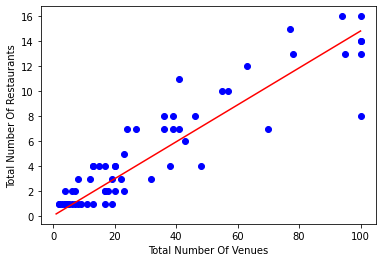

In [52]:
plt.scatter(toronto_all.Number_Of_Venues, toronto_all.Number_Of_Restaurants,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Total Number Of Venues")
plt.ylabel("Total Number Of Restaurants")

In [125]:


toronto_list = pd.merge(toronto_top10[['Neighborhood']],toronto_venues[['Neighborhood', 'Venue','Venue Category','Venue Latitude','Venue Longitude']],
                
                 on='Neighborhood', 
                 how='left')
toronto_list_other_rest=toronto_list[toronto_list['Venue Category'].str.contains("Restaurant")]
toronto_list_other_rest=toronto_list_other_rest[toronto_list_other_rest['Venue Category'] != 'Indian Restaurant']
toronto_clustering.shape

(226, 2)

In [126]:
# set number of clusters
kclusters =  5

toronto_clustering_new = toronto_list_other_rest[['Venue Latitude','Venue Longitude']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 3])

In [127]:
# add clustering labels

toronto_list_other_rest.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_list_other_rest.head()



,Cluster Labels,Neighborhood,Venue,Venue Category,Venue Latitude,Venue Longitude
14,2,"Harbourfront East , Union Station , Toronto Is...",e11even,New American Restaurant,43.642426,-79.381441
17,3,"Harbourfront East , Union Station , Toronto Is...",Miku,Japanese Restaurant,43.641374,-79.377531
25,2,"Harbourfront East , Union Station , Toronto Is...",Pearl Harbourfront,Chinese Restaurant,43.638157,-79.380688
27,2,"Harbourfront East , Union Station , Toronto Is...",Taverna Mercatto,Italian Restaurant,43.642625,-79.383257
54,3,"Harbourfront East , Union Station , Toronto Is...",Kupfert & Kim,Vegetarian / Vegan Restaurant,43.641179,-79.378144


In [128]:

import folium # map rendering library


# create map
map_clusters = folium.Map(location=[city_center_latitude, city_center_longitude], zoom_start=11)

# set color scheme for the clusters

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, vc, cluster in zip(toronto_list_other_rest['Venue Latitude'], toronto_list_other_rest['Venue Longitude'], toronto_list_other_rest['Neighborhood'],toronto_list_other_rest['Venue Category'], toronto_list_other_rest['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters